In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad
from scipy.optimize import curve_fit
import time


# 1) Inelastic pp-interaction cross section $\sigma_{pp}$($E$)

In [3]:
def cross_section(E):
    L = np.log(E/10**3)
    E_th = 1.22#*10**(-3) 
    return (34.3+1.88*L+0.25*pow(L,2))*pow((1-pow((E_th/E),4)),2)

# 2) CR energy luminosity due to supernovae 

In [4]:
def E_CR(RSN): #RSN in yr^-1
    E_SN = 1e51 #characteristic energy output
    xi = 0.1 # efficiency ~10%
    erg = 624.15 # conversion erg -> GeV
    yr_to_sec = 31556926 #seconds
    R_sn = RSN*(1/yr_to_sec) # SN rate in seconds
    return R_sn*E_SN*erg*xi


# 3) Normalisation constant $N_{C,SN}$

In [5]:
def integrand(p, alpha,pmax):
    m_p = 0.938 #GeV/c²
    p_max = pmax #GeV/c
    return (4*np.pi)*pow(p,2)*pow(p/m_p,-alpha)*np.exp(-p/p_max)*(np.sqrt(pow(p,2)+pow(0.938,2))-0.938) 


In [6]:

def N_C(ECR, alpha, pmax): #normalisation constant
    integral = integrate.quad(integrand,.0001,np.inf, args = (alpha,pmax))
    return ECR/integral[0]

# 4) Proton injection rate Q$_p$

In [7]:
def Q2(p,Rsn, R , al, N,pmax):
    yr_to_sec = 31556926 
    R_sn = Rsn*(1/yr_to_sec) #s
    R = R*3.08567758*1e18  #pc to cm conversion
    V_SBN = (4/3)*np.pi*pow(R,3)
    m_p = 0.938
    p_max = pmax
    return (N/V_SBN)*pow(p/m_p,-al)*np.exp(-p/p_max)

# 5) Time scales 

## 5.1) Inelastic scatterings $\tau_{loss}$


In [8]:
def loss_time(E,nism,u): 
    eta = 0.51
    sec_to_year = 3.16887646*1e-8 #year
    n = nism*(1/1e-6) # cm-3 -> m^-3
    if(u == 0):#u==0 then units are  year, otherwise seconds
        c = 3e8*(1/sec_to_year) #m/year
        sigma = cross_section(E)*1e-31 #mb -> m² 
        return 1/(eta*n*sigma*c)
        
    else: 
        c = 3e8
        sigma = cross_section(E)*1e-31
        return 1/(eta*n*sigma*c)

## 5.2) Wind speed $\tau_{gwind}$

In [9]:
def tau_wind(R,v,u):
    R_SBN= R*3.08567758*1e16 # pc to m
    sec = 3.16887646*1e-8 #s conversion from sec to yr
    if(u==0): #time scale in years
        v_wind = v*1000*(1/sec) 
        return (R_SBN/v_wind) 
    
    else:#time scale in seconds
        v_wind = v*1000 
        return (R_SBN/v_wind) 

## 5.3) total lifetime $\tau_{life}$

In [10]:
def tau_lifetime(R,vwind,E , nism):
    return pow(pow(tau_wind(R,vwind,1),-1)+pow(loss_time(E,nism,1),-1),-1)

# 6) Proton momentum distribution function $f_p$

In [11]:
def f_p(E, nism,R, v, Rsn, alpha, pmax):
    return tau_lifetime(R,v, E, nism)*Q2(E,Rsn,R,alpha,N_C(E_CR(Rsn),alpha,pmax),pmax)

# 7) Pion injection rate


In [12]:
def q_pi(E,nism,R,v,Rsn,alpha, pmax):
    n = nism*1e6
    c = 3e8    
    K_pi = 0.17 # kinetic energy transfor parent proton to pion 
    m_p = 0.938 # GeV
    return (c*n)*(1/K_pi)*(cross_section((E/K_pi)+0.938)*1e-31)*4*np.pi*pow((E/K_pi)+0.938,2)*tau_lifetime(R,v, (E/K_pi)+0.938, nism)*Q2(E/K_pi+0.938,Rsn,R,alpha,N_C(E_CR(Rsn),alpha,pmax),pmax)

# 8) PDFs pion-to-neutrino decay 

In [13]:
def g_mu(x):
    r = 0.573
    return (9*pow(x,2)-6*np.log(x)-4*pow(x,3)-5)*(3-2*r)/(9*pow(1-r,2))

def h_mu1(x):
    r = 0.573
    return (9*pow(r,2)-6*np.log(r)-4*pow(r,3)-5)*(3-2*r)/(9*pow(1-r,2))

def h_mu2(x):
    r = 0.573
    return ((9*(r+x)-4*(pow(r,2)+r*x+pow(x,2)))*(1+2*r)*(r-x))/(9*pow(r,2))



def ge(x):
    r = 0.573
    #if u==0:
    return 2*(((1-x)*(6*(1-x)**2+r*(5+5*x-4*x**2))+6*r*np.log(x)))/(3*(1-r)**2)
    #else:
        #return ((2*(1-x))/(3*pow((1-r),2)))*(((1-r)*(6*pow((1-x),2)+r*(5+5*x-4*pow(x,2)))+6*r*np.log(x)))



def h_e1(x):
    r = 0.573
    return (2/(3*(pow((1-r),2))))*((1-r)*(6-7*r+11*pow(r,2)-4*pow(r,3))+6*r*np.log(r))

def h_e2(x):
    r = 0.573
    return((2*(r-x))/(3*pow(r,2))) *(7*pow(r,2)-4*pow(r,3)+7*x*r-4*x*pow(r,2)-2*pow(x,2)-4*pow(x,2)*r)

In [14]:
def f_mu1(x):
    lambd = 1-0.573
    if (lambd-x>=0):
        return 1/lambd
    else: 
        return 0

def f_mu2(x):
    r = 0.573
    if (x-r>=0):
        return g_mu(x)
    if (r-x>=0):
        return h_mu1(x)+h_mu2(x)
        
    else:
        return 0

def f_ve(x):
    r =0.573
    if (x - r >= 0):
        return ge(x)
    if (r-x > 0):
        return h_e1(x)+h_e2(x)
    else:
        return 0
   
   

# 8) Neutrino production rate $q_{\nu}/3$

In [15]:
def q_nu(x,E_nu, nism,R,v,Rsn,alpha,pmax):
    return (2/3)*(f_mu1(x)+f_mu2(x)+f_ve(x))*q_pi(E_nu/x, nism,R,v,Rsn,alpha,pmax)*(1/x)

# 9) Flux generator 

In [16]:
def flux_generator(nism,R,v,Rsn,alpha,pmax,D_L):
    DL = D_L *1e6 * 3.08567758* 1e18
    
    E = np.arange(1e2,1e5,1e3)
    E2 = np.arange(1e5,1e7,1e5)
    
    fluxes = []
    fluxes2 = []
    for i in E: 
        I = quad(q_nu,0,1,args = (i,nism,R,v,Rsn,alpha,pmax) )[0] #takes factor three already into account
        fluxes += [I]
    for i in E2: 
        I = quad(q_nu,0,1,args = (i,nism,R,v,Rsn,alpha,pmax) )[0] #takes factor three already into account
        fluxes2 += [I]
        
    fluxes = np.array(fluxes)
    fluxes2 = np.array(fluxes2)
    
    V = ((4/3)*np.pi)*pow(R* 3.08567758* 1e18 ,3 )#Mpc -> meter
    
    scaled_flux = (V/(4*np.pi*pow(DL,2)))*pow(E,2)*fluxes
    scaled_flux2 = (V/(4*np.pi*pow(DL,2)))*pow(E2,2)*fluxes2
    scaled_flux_final = np.concatenate((scaled_flux,scaled_flux2))
    
    return [np.concatenate((E,E2)),scaled_flux_final]

* ISM density $n_{ism}$ in cm$^{-3}$


* Radius starburst region $R$ in pc 


* Galactic superwind speed $v$ in km/s



* Supernova rate $\mathcal{R}_{SN}$ in yr$^{-1}$



* Power-law index $\alpha_{SN}$ dimensionless



* $D_L$ in Mpc


# $\quad$ $\quad$ $\quad$  ~ 10)  Computations flux Arp 220, M82, and NGC 253 ~

## sin($\delta$) values for Arp 220, M82, and NGC 253 from https://ned.ipac.caltech.edu/

In [17]:
#M82, dec = 69° 40' 47"

sin_dec_M82 = np.sin(69.67972*(np.pi/180))
sens_flux_M82 = (8.7*1e-13)*(1/1000)*pow(1*1e3,2) #[GeVcm-2s-1]
print("sin_dec M82: "+ str(sin_dec_M82))

#NGC253, dec = −25° 17′ 18″

sin_dec_NGC253 = -np.sin(25.28833*(np.pi/180))
sens_flux_NGC253 = 1.90e-12*(1/1000)*pow(1*1e3,2)
print("sin_dec NGC253: " + str(sin_dec_NGC253))

#Arp 220

sin_dec_ARP220 = np.sin(23.50322*(np.pi/180))
print("sin_dec ARP220: " + str(sin_dec_ARP220))
sens_flux_ARP220 = 3.46e-13*(1/1000)*pow(1*1e3,2)

#ARP 299-A
sin_dec_ARP299A = np.sin(58.56611*(np.pi/180))
print("sin_dec ARP299A: "+str(sin_dec_ARP299A))
sens_flux_ARP299AA = 5.785154691896414e-13*(1/1000)*pow(1*1e3,2)

sin_dec M82: 0.937766077028211
sin_dec NGC253: -0.4271737110591454
sin_dec ARP220: 0.3988006067066273
sin_dec ARP299A: 0.8532424749077681


## 90 % Central energy ranges Arp 220, M82, and NGC 253 from https://arxiv.org/abs/1910.08488

In [18]:
E_sens = np.arange(pow(10,2.639239495127017),pow(10,4.087394152420514),1e3)
Flux_sens = np.repeat(sens_flux_M82, len(E_sens))

E_sens_ARP220 = np.arange(pow(10,2.7689904315563365),pow(10,4.653015213647903),1e3)
Flux_sens_ARP220 = np.repeat(sens_flux_ARP220, len(E_sens_ARP220))


E_sens_NGC253 = np.arange(pow(10,4.647227991691963),pow(10,6.573432035646446),1e3)
Flux_sens_NGC253 = np.repeat(sens_flux_NGC253, len(E_sens_NGC253))



## M82 flux generator 

In [19]:
F = flux_generator(175,220,600,0.05,4.25,1e8,3.9)

In [20]:
#F_p = flux_generator(150,200,700,0.05,4.20,1e8,3.9)

## Arp 220 flux generator

In [21]:
F2 = flux_generator(3500,250,500,2.25,4.45,1e8,77)

## NGC 253 flux generator 

In [22]:
F3 = flux_generator(250,150,300,0.027,4.30,1e8,3.8)


Text(0, 0.5, 'E$_{\\nu_{\\mu}}^2$ F$_{\\nu_\\mu}$ \n [GeV cm$^{-2}$ s$^{-1}$] \n')

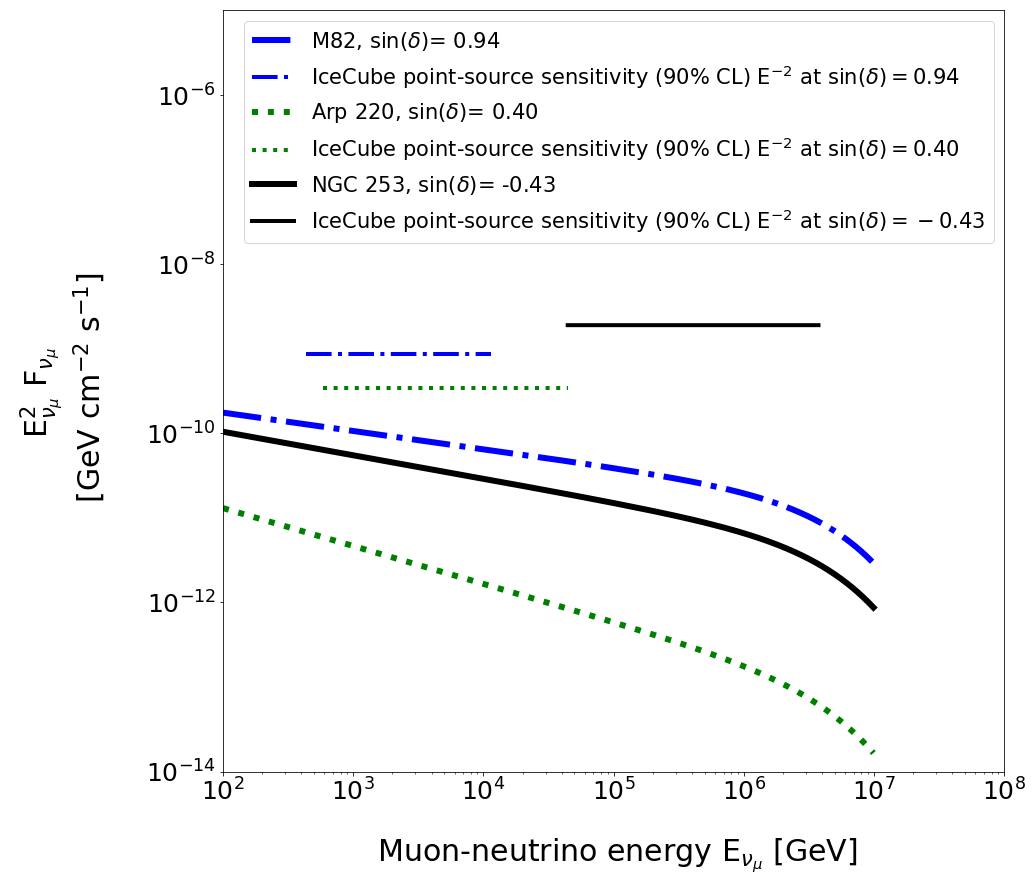

In [23]:
fig3 = plt.figure(figsize=(14,14))

#plt.scatter(momentum_prototype,Flux_prototype, color = 'r', label = 'Peretti et al.')
#plt.plot(F_p[0],F_p[1],'b-.', label = 'M82, sin($\\delta$)= 0.94', linewidth = 6)


plt.plot(F[0],F[1],'b-.', label = 'M82, sin($\\delta$)= 0.94', linewidth = 6)
plt.plot(E_sens, Flux_sens, label = "IceCube point-source sensitivity (90% CL) E$^{-2}$ at sin($\\delta) = 0.94$", linestyle = '-.', c='b' ,linewidth = 4)


plt.plot(F2[0],F2[1], label = 'Arp 220, sin($\\delta$)= 0.40', linestyle = 'dotted', c='g', linewidth = 6)
plt.plot(E_sens_ARP220, Flux_sens_ARP220, label = "IceCube point-source sensitivity (90% CL) E$^{-2}$ at sin($\\delta) = 0.40$", c='g',linewidth = 4, linestyle = 'dotted')


plt.plot(F3[0],F3[1], label = 'NGC 253, sin($\\delta$)= -0.43', c= 'k', linewidth = 6)
plt.plot(E_sens_NGC253, Flux_sens_NGC253, label = "IceCube point-source sensitivity (90% CL) E$^{-2}$ at sin($\\delta) = -0.43$", c= 'k', linewidth = 4)


plt.legend(fontsize = 18, bbox_to_anchor=(1.04,1), loc="upper left")
plt.legend(fontsize = 21)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-14,1e-5)
plt.xlim(1e2,1e8)
plt.ylim()
plt.xticks(fontsize = 25)
plt.yticks(fontsize= 25)
plt.xlabel('\n Muon-neutrino energy E$_{\\nu_{\\mu}}$ [GeV] ',fontsize = 30)
plt.ylabel('E$_{\\nu_{\\mu}}^2$ F$_{\\nu_\\mu}$ \n [GeV cm$^{-2}$ s$^{-1}$] \n', fontsize = 30)

# $\quad$ $\quad$ $\quad$ $\quad$ $\quad$ $\quad$ $\quad$  $\quad$ 10.1) Varying pmax

In [24]:
F_10PeV = flux_generator(3500,250,500,2.25,4.45,1e7,77)
F_20PeV = flux_generator(3500,250,500,2.25,4.45,2e7,77)
F_30PeV = flux_generator(3500,250,500,2.25,4.45,3e7,77)
F_100PeV = flux_generator(3500,250,500,2.25,4.45,1e8,77)

In [25]:
F_NGC253_10 = flux_generator(250,150,300,0.027,4.30,1e7,3.8)
F_NGC253_20 = flux_generator(250,150,300,0.027,4.30,2e7,3.8)
F_NGC253_30 = flux_generator(250,150,300,0.027,4.30,3e7,3.8)
F_NGC253_100 = flux_generator(250,150,300,0.027,4.30,1e8,3.8)

Text(0, 0.5, '$E_{\\nu_\\mu}^2$ F$_{\\nu_\\mu}$ \n [GeV cm$^{-2}$ s$^{-1}$]')

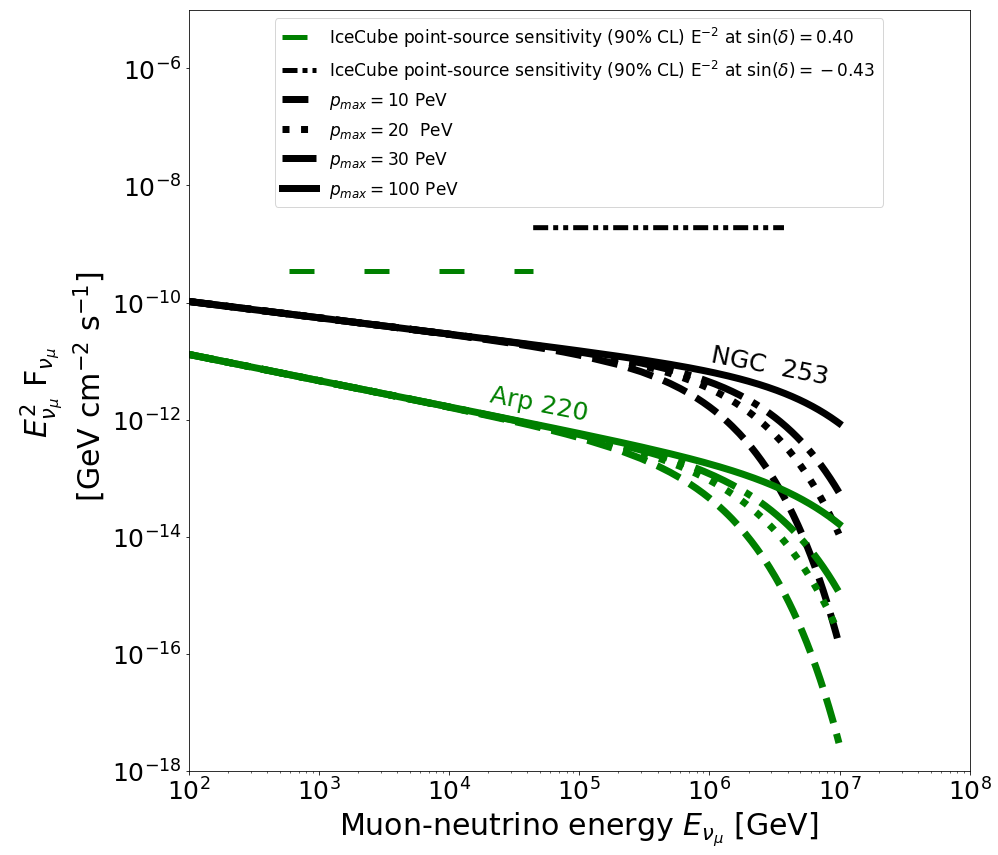

In [26]:
fig3 = plt.figure(figsize=(14,14))

plt.plot(E_sens_ARP220, Flux_sens_ARP220, label = "IceCube point-source sensitivity (90% CL) E$^{-2}$ at sin($\\delta) = 0.40$", c='g',linewidth = 5, linestyle = (0,(5,10)))
plt.plot(E_sens_NGC253, Flux_sens_NGC253, label = "IceCube point-source sensitivity (90% CL) E$^{-2}$ at sin($\\delta) = -0.43$ ", c= 'k', linewidth = 5, linestyle = (0,(3,1,1,1,1,1)))

plt.plot(F_NGC253_10[0], F_NGC253_10[1],'k--', label = '$p_{max} = 10$ PeV', linewidth = 7)
plt.plot(F_NGC253_20[0], F_NGC253_20[1], label = '$p_{max} = 20$  PeV', linewidth = 7,c='k', linestyle = 'dotted')
plt.plot(F_NGC253_30[0], F_NGC253_30[1],label = '$p_{max} = 30$ PeV',linewidth = 7, c='k', linestyle = 'dashdot')
plt.plot(F_NGC253_100[0], F_NGC253_100[1],linewidth = 7, c='k', label = '$p_{max} = 100$ PeV')
plt.text(1e6,1e-11, 'NGC  253', fontsize = 25 , rotation = -11)



plt.plot(F_10PeV[0], F_10PeV[1],'g--',linewidth = 7)
plt.plot(F_20PeV[0], F_20PeV[1],linestyle = 'dotted',  linewidth = 7,c='g')
plt.plot(F_30PeV[0], F_30PeV[1],linestyle = 'dashdot',linewidth = 7, c= 'g')
plt.plot(F_100PeV [0], F_100PeV[1],linewidth = 7, c= 'g')
plt.text(2e4,2e-12, 'Arp 220', fontsize = 25 , rotation = -11, color = 'green')


plt.legend(fontsize = 17, loc= 'upper center')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-18,1e-5)
plt.xlim(1e2,1e8)
plt.ylim()
plt.xticks(fontsize = 25)
plt.yticks(fontsize= 25)
plt.xlabel('Muon-neutrino energy $E_{\\nu_\\mu}$ [GeV]',fontsize = 30)
plt.ylabel('$E_{\\nu_\\mu}^2$ F$_{\\nu_\\mu}$ \n [GeV cm$^{-2}$ s$^{-1}$]', fontsize = 30)

#  $\quad$ $\quad$ $\quad$ $\quad$ $\quad$ $\quad$  $\quad$  10.2) Parameter robustness 

## $\quad$ - M82 -

### double SN rate

In [27]:
FM82_double = flux_generator(175,220,600,0.10,4.25,1e8,3.9)
FM82_half = flux_generator(175,220,600,0.05/2,4.25,1e8,3.9)

### Wind speed: 2000 km/s

In [28]:
FM82_hotwind = flux_generator(175,220,2000,0.05,4.25,1e8,3.9)

### Calorimeter 

In [29]:
F_calori = flux_generator(1e12,220,600,0.05,4.25,1e8,3.9)

## $\quad$ - Arp 220 -

### double SN rate

In [30]:
Farp220_double = flux_generator(3500,250,500,2.25*2,4.45,1e8,77)
Farp220_half = flux_generator(3500,250,500,2.25/2,4.45,1e8,77)


### Wind speed: 2000 km/s

In [31]:
Farp220_hotwind = flux_generator(3500,250,2000,2.25,4.45,1e8,77)


### Calorimeter 

In [32]:
F2_calori = flux_generator(1e12,250,500,2.25,4.45,1e8,77)

### Spectral index

In [33]:
F2_spectral = flux_generator(3500,250,500,2.25,4.35,1e8,77)

## $\quad$ - NGC 253 -

### Double SN rate

In [34]:
Fngc253_double = flux_generator(250,150,300,0.027*2,4.30,1e8,3.8)
Fngc253_half = flux_generator(250,150,300,0.027/2,4.30,1e8,3.8)


### Wind speed: 2000 km/s

In [35]:
Fngc253_hotwind = flux_generator(250,150,2000,0.027,4.30,1e8,3.8)


### Calorimeter

In [36]:
F3_calori = flux_generator(1e12,150,300,0.027,4.30,1e8,3.8)

# Plotting


Text(0, 0.5, 'E$_{\\nu_{\\mu}}^2$ F$_{\\nu_\\mu}$ \n [GeV cm$^{-2}$ s$^{-1}$] \n')

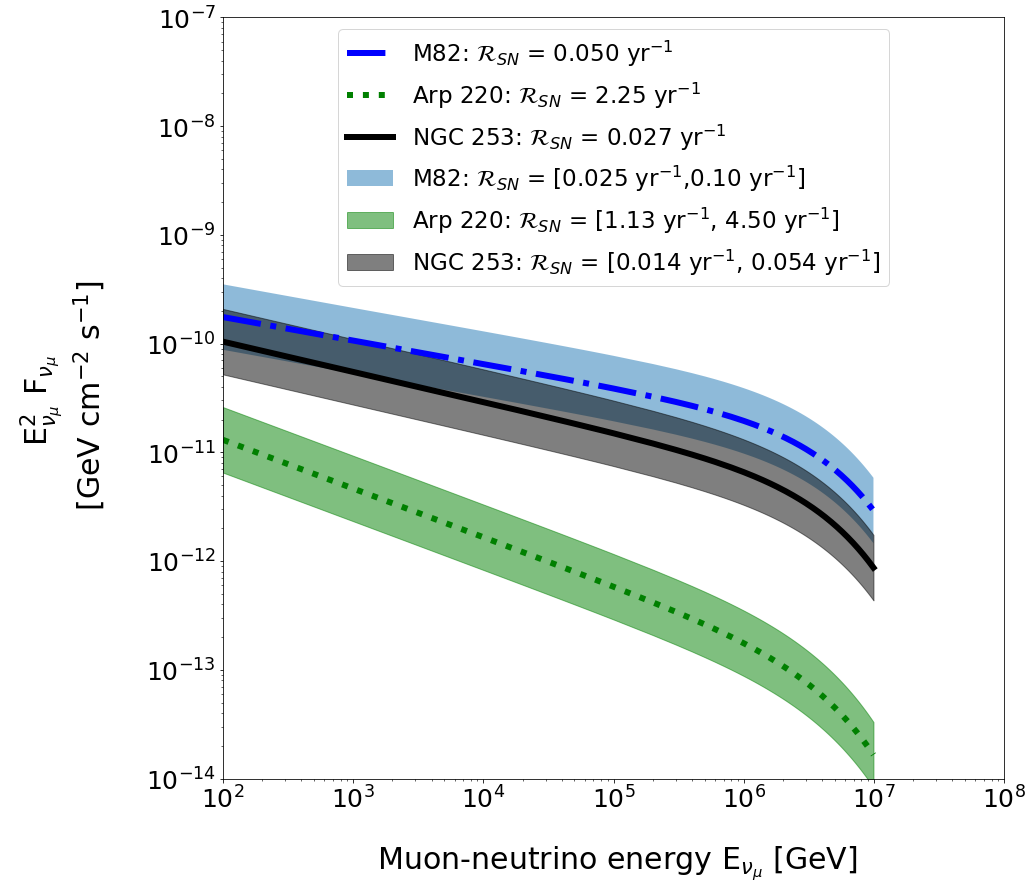

In [37]:
fig3 = plt.figure(figsize=(14,14))


plt.plot(F[0],F[1],'b-.', label = 'M82: $\mathcal{R}_{SN}$ = 0.050 yr$^{-1}$', linewidth = 6)
plt.fill_between(FM82_double[0],FM82_half[1],FM82_double[1], alpha = 0.5, label = 'M82: $\mathcal{R}_{SN}$ = [0.025 yr$^{-1}$,0.10 yr$^{-1}$]')
#plt.plot(E_sens, Flux_sens, label = "IceCube point-source sensitivity (90% CL) E$^{-2}$ at sin($\\delta) = 0.94$", linestyle = '-.', c='b' ,linewidth = 5)

plt.plot(F2[0],F2[1], label = 'Arp 220: $\mathcal{R}_{SN}$ = 2.25 yr$^{-1}$', linestyle = 'dotted', c='g', linewidth = 6)
plt.fill_between(Farp220_double[0],Farp220_half[1],Farp220_double[1], alpha = 0.5, color= 'g', label = 'Arp 220: $\mathcal{R}_{SN}$ = [1.13 yr$^{-1}$, 4.50 yr$^{-1}$]')
#plt.plot(E_sens_ARP220, Flux_sens_ARP220, label = "IceCube point-source sensitivity (90% CL) E$^{-2}$ at sin($\\delta) = 0.40$", c='g',linewidth = 5, linestyle = 'dotted')


plt.plot(F3[0],F3[1], label = 'NGC 253: $\mathcal{R}_{SN}$ = 0.027 yr$^{-1}$', c= 'k', linewidth = 6)
#plt.plot(E_sens_NGC253, Flux_sens_NGC253, label = "IceCube point-source sensitivity (90% CL) E$^{-2}$ at sin($\\delta) = -0.43$", c= 'k', linewidth = 5)
plt.fill_between(Fngc253_double[0],Fngc253_half[1],Fngc253_double[1], alpha = 0.5, color='k', label = 'NGC 253: $\mathcal{R}_{SN}$ = [0.014 yr$^{-1}$, 0.054 yr$^{-1}$]' )

plt.legend(fontsize = 23, loc="upper center")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-14,1e-7)
plt.xlim(1e2,1e8)
plt.ylim()
plt.xticks(fontsize = 25)
plt.yticks(fontsize= 25)
plt.xlabel('\n Muon-neutrino energy E$_{\\nu_{\\mu}}$ [GeV] ',fontsize = 30)
plt.ylabel('E$_{\\nu_{\\mu}}^2$ F$_{\\nu_\\mu}$ \n [GeV cm$^{-2}$ s$^{-1}$] \n', fontsize = 30)

Text(0, 0.5, 'E$_{\\nu_{\\mu}}^2$ F$_{\\nu_\\mu}$ \n [GeV cm$^{-2}$ s$^{-1}$] \n')

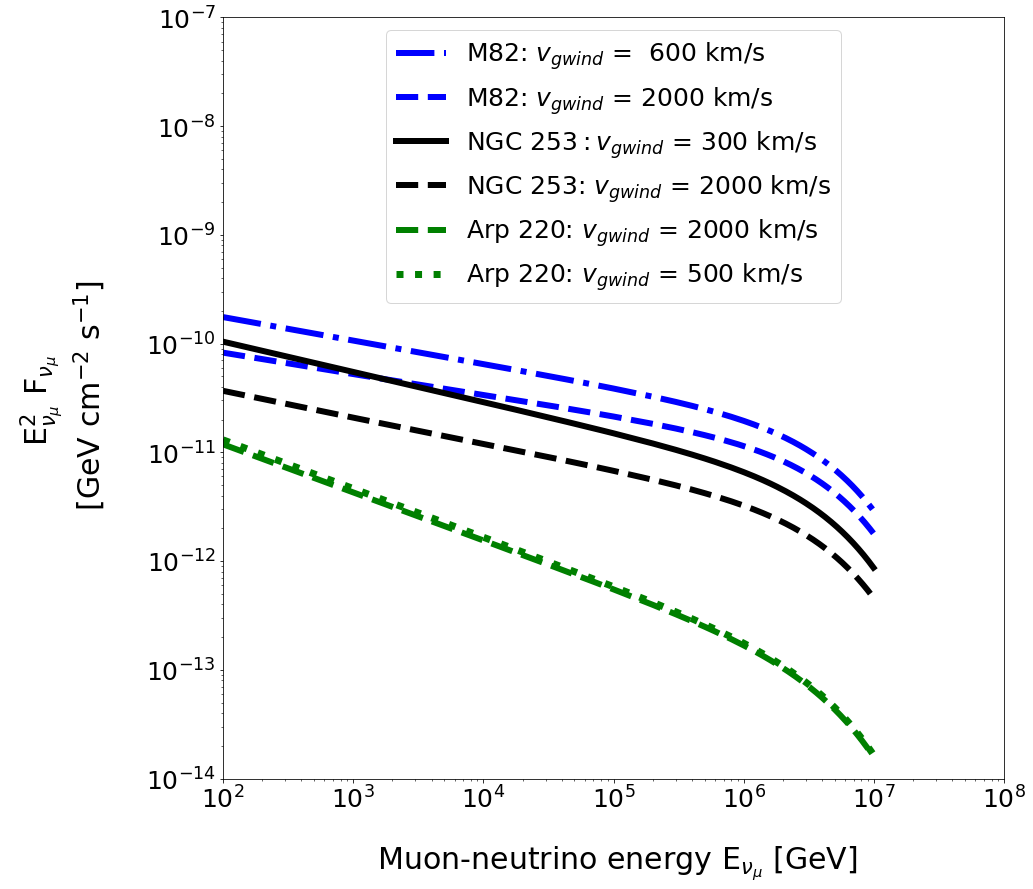

In [38]:
fig3 = plt.figure(figsize=(14,14))

#plt.ylim(1e-14,1e-5)


plt.plot(F[0],F[1],'b-.', label = 'M82: $v_{gwind}$ =  600 km/s', linewidth = 6)
plt.plot(FM82_hotwind[0],FM82_hotwind[1],linestyle = 'dashed',c='b', linewidth = 6,label = 'M82: $v_{gwind}$ = 2000 km/s')

plt.plot(F3[0],F3[1], label = 'NGC 253$: v_{gwind}$ = 300 km/s', c= 'k', linewidth = 6)
plt.plot(Fngc253_hotwind[0],Fngc253_hotwind[1],linestyle = 'dashed', c= 'k', linewidth = 6,label = 'NGC 253: $v_{gwind}$ = 2000 km/s')

plt.plot(Farp220_hotwind[0],Farp220_hotwind[1],linestyle = 'dashed', c='g', linewidth = 6, label = 'Arp 220: $v_{gwind}$ = 2000 km/s')
plt.plot(F2[0],F2[1], label = 'Arp 220: $v_{gwind}$ = 500 km/s', linestyle = 'dotted', c='g', linewidth = 7)


plt.legend(fontsize = 25, loc="upper center")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-14,1e-7)

plt.xlim(1e2,1e8)
plt.xticks(fontsize = 25)
plt.yticks(fontsize= 25)
plt.xlabel('\n Muon-neutrino energy E$_{\\nu_{\\mu}}$ [GeV] ',fontsize = 30)
plt.ylabel('E$_{\\nu_{\\mu}}^2$ F$_{\\nu_\\mu}$ \n [GeV cm$^{-2}$ s$^{-1}$] \n', fontsize = 30)

Text(0, 0.5, 'E$_{\\nu_{\\mu}}^2$ F$_{\\nu_\\mu}$ \n [GeV cm$^{-2}$ s$^{-1}$] \n')

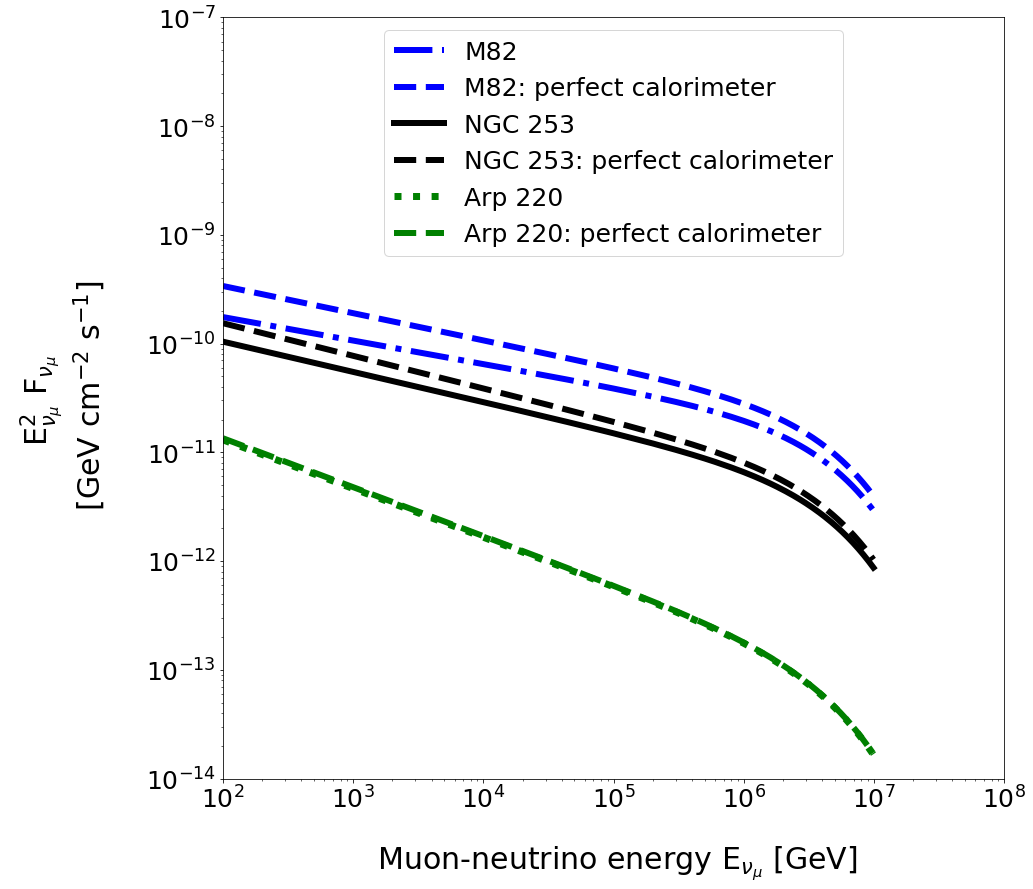

In [39]:
fig3 = plt.figure(figsize=(14,14))

plt.plot(F[0],F[1],'b-.', label = 'M82', linewidth = 6)
plt.plot(F_calori[0],F_calori[1],linestyle = 'dashed',c='b', linewidth = 6,label = 'M82: perfect calorimeter')

plt.plot(F3[0],F3[1], label = 'NGC 253', c= 'k', linewidth = 6)
plt.plot(F3_calori[0],F3_calori[1],linestyle = 'dashed', c= 'k', linewidth = 6,label = 'NGC 253: perfect calorimeter')


plt.plot(F2[0],F2[1], label = 'Arp 220', linestyle = 'dotted', c='g', linewidth = 7)
plt.plot(F2_calori[0],F2_calori[1],linestyle = 'dashed', c='g', linewidth = 6, label = 'Arp 220: perfect calorimeter')




plt.legend(fontsize = 25, loc="upper center")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-14,1e-7)
plt.xlim(1e2,1e8)
plt.xticks(fontsize = 25)
plt.yticks(fontsize= 25)
plt.xlabel('\n Muon-neutrino energy E$_{\\nu_{\\mu}}$ [GeV] ',fontsize = 30)
plt.ylabel('E$_{\\nu_{\\mu}}^2$ F$_{\\nu_\\mu}$ \n [GeV cm$^{-2}$ s$^{-1}$] \n', fontsize = 30)

#  $\quad$ $\quad$ $\quad$ $\quad$ $\quad$ ~ 11) Computations flux Arp 299-A ~

## Case 1

In [40]:

Farp299A = flux_generator(5e3,150,370,0.8,4.2,1e8,45)
Farp299A2 = flux_generator(5e3,150,370,0.8,4.45,1e8,45)

## Case 2

In [41]:
Farp299A3 = flux_generator(1e3,150,890,0.8,4.2,1e8,45)
Farp299A4 = flux_generator(1e3,150,890,0.8,4.45,1e8,45)

## Case 3

In [42]:
Farp299A5 = flux_generator(5e3,150,890,1.6,4.20,1e8,45)
Farp299A6 = flux_generator(5e3,150,890,1.6,4.45,1e8,45)

## Plotting

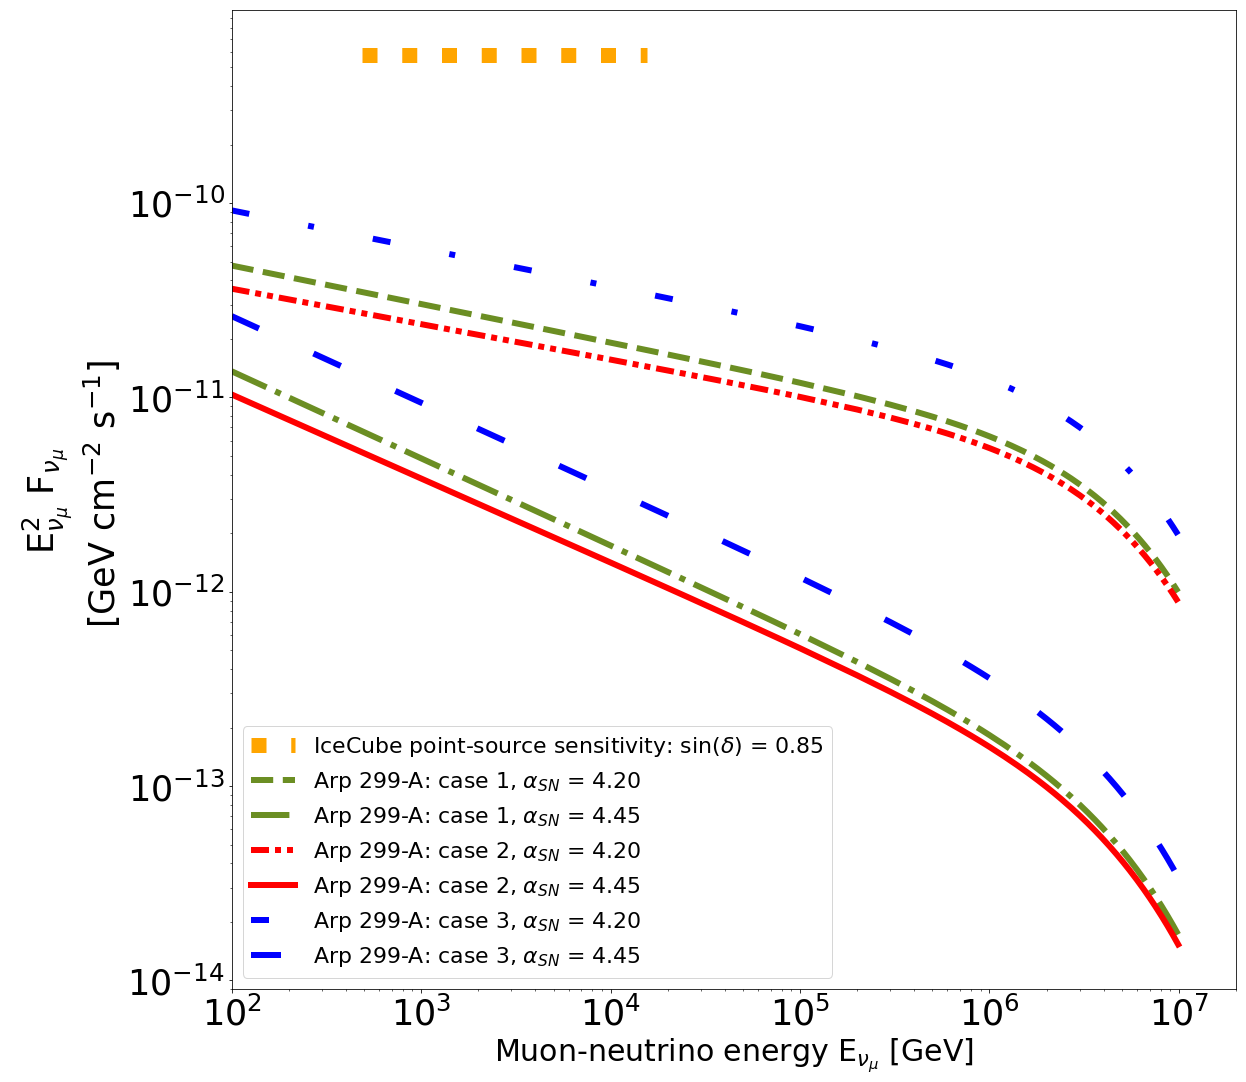

In [43]:
fig3 = plt.figure(figsize=(18,18))


#plt.fill_between(F[0],F[1],F2[1],label = 'Area between flux results Arp 220 and M82 ', color = 'grey', hatch = '/', alpha = 0.5)

E_sens_ARP299AA = np.arange(pow(10,2.6872787803397697),pow(10,4.211878106089287),1e3)
Flux_sens_ARP299AA = np.repeat(sens_flux_ARP299AA, len(E_sens_ARP299AA))

plt.plot(E_sens_ARP299AA, Flux_sens_ARP299AA, label = "IceCube point-source sensitivity: sin($\\delta$) = 0.85", c='orange',linewidth = 15, linestyle = 'dotted')


plt.plot(Farp299A[0], Farp299A[1], color = 'olivedrab', linestyle = '--', linewidth = 6, label = 'Arp 299-A: case 1, $\\alpha_{SN}$ = 4.20')
plt.plot(Farp299A2[0], Farp299A2[1], color = 'olivedrab', linestyle = '-.', linewidth = 6, label = 'Arp 299-A: case 1, $\\alpha_{SN}$ = 4.45 ')

plt.plot(Farp299A3[0], Farp299A3[1], color = 'red', linestyle = (0,(3,1,1,1,1,1)), linewidth = 6, label =  'Arp 299-A: case 2, $\\alpha_{SN}$ = 4.20')
plt.plot(Farp299A4[0], Farp299A4[1], color = 'red', linewidth = 6, label =  'Arp 299-A: case 2, $\\alpha_{SN}$ = 4.45', )


plt.plot(Farp299A5[0], Farp299A5[1], color = 'blue', linestyle  = (0, (3, 10, 1, 10)), linewidth = 6, label = 'Arp 299-A: case 3, $\\alpha_{SN}$ = 4.20')
plt.plot(Farp299A6[0], Farp299A6[1], color = 'blue', linewidth = 6, linestyle = (0,(5,10)), label = 'Arp 299-A: case 3, $\\alpha_{SN}$ = 4.45' )



plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2,2e7)
plt.ylim()
plt.xticks(fontsize = 35)
plt.yticks(fontsize= 35)
plt.xlabel('Muon-neutrino energy E$_{\\nu_\\mu}$ [GeV]',fontsize = 30)
plt.ylabel('E$_{\\nu_\\mu}^2$ F$_{\\nu_\\mu}$ \n [GeV cm$^{-2}$ s$^{-1}$]', fontsize = 35)
plt.legend(fontsize = 22, loc = 'best')
